---
### Building Models
(Ref. : https://github.com/jrzaurin/Wide-and-Deep-PyTorch)
- These are the steps for building tensorflow's wide and deep learning model using PyTorch.
- Steps:
  - 1) Prepare data set
  - 2-1) Build PyTorch model for **the Wide part**
  - 2-2) Build PyTorch model for **the Deep part**
  - 3) Combine **the Wide and the Deep part model** to make final wide and deep learning model 
---

In [1]:
import numpy as np
import pandas as pd

import os, copy

from wide_and_deep.utils import prepare_dataset

---
#### 1) Prepare data set
---

In [2]:
### Load the data set from '.data/audult_data.csv'
raw_df = pd.read_csv(os.path.join(str(os.getcwd()), 'data/adult_data.csv'))

raw_df['income_label'] = raw_df['income_bracket'].apply(lambda x: 1 if '>50K' in x or '>50K.' in x else 0)
print('Target : {} / Non-Target : {}'.format(len(raw_df[raw_df.income_label == 1]), len(raw_df[raw_df.income_label != 1])))

# For Wide and Crossed network (for memorization)
wide_cols = ['age','hours_per_week','education', 'relationship','workclass',
             'occupation','native_country','gender']
crossed_cols = (['education', 'occupation'], ['native_country', 'occupation']) # pair-combination 

# For Deep network (embedding + continuous) (for generalization)
continuous_cols = ["age","hours_per_week"]

embeddings_cols = [('education',10), ('relationship',8), ('workclass',10),
                    ('occupation',10),('native_country',12)] # column name / embedding dim.

Target : 11687 / Non-Target : 37155


In [3]:
out_dataset = prepare_dataset(raw_df, wide_cols, crossed_cols, embeddings_cols, 
                              continuous_cols, target = 'income_label', scale = True, seed = 1)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


return key values dict_keys(['train_set', 'test_set', 'embeddings_input', 'deep_column_idx', 'encoding_dict'])


---
### 2-1) Wide part
---

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *

#### the Wide part : 
 - build the Wide part for memorization
 - this part would be simple regresssion model with one Linear layer
   - Input dimension : the number of features in wide part
   - Output dimension : one for regression output (activated with sigmoid function)

In [5]:
wide_dim = out_dataset['train_set'].wide.shape[1]
n_class  = 1
wide_part = nn.Linear(wide_dim, n_class)

print(wide_part)

Linear(in_features=798, out_features=1, bias=True)


In [6]:
### define the class for wide network
class wideNet(nn.Module):
    
    def __init__(self, wide_dim, n_class):
        super(wideNet, self).__init__()
        self.wide_dim = wide_dim
        self.n_class = n_class
        
        self.ly1 = nn.Linear(self.wide_dim, self.n_class)
#         self.ly1 = nn.Linear(self.wide_dim, 10)
#         self.ly2 = nn.Linear(10, self.n_class)
        
    def forward(self, x):
        out = F.sigmoid(self.ly1(x))
#         x = F.sigmoid(self.ly1(x))
#         out = F.sigmoid(self.ly2(x))
        
        return out

In [7]:
net = wideNet(wide_dim, n_class)
print(net)

wideNet(
  (ly1): Linear(in_features=798, out_features=1, bias=True)
)


In [8]:
# make dataloader for train/test set of the Wide part
w_train_x = torch.tensor(out_dataset['train_set'].wide, dtype=torch.float)
w_train_y = torch.tensor(out_dataset['train_set'].labels.reshape(-1,1), dtype=torch.float)
print(w_train_x.size(), w_train_y.size())

w_test_x = torch.tensor(out_dataset['test_set'].wide, dtype=torch.float)
w_test_y = torch.tensor(out_dataset['test_set'].labels.reshape(-1,1), dtype=torch.float)
print(w_test_x.size(), w_test_y.size())

batch_size = 64

# convert Torch tensors to TensorDataset with batch size
w_train_set = TensorDataset(w_train_x, w_train_y)
w_train_loader = DataLoader(w_train_set, batch_size, shuffle = True, num_workers=1)

w_test_set = TensorDataset(w_test_x, w_test_y)
w_test_loader = DataLoader(w_test_set, batch_size, shuffle = True, num_workers=1)

torch.Size([34189, 798]) torch.Size([34189, 1])
torch.Size([14653, 798]) torch.Size([14653, 1])


In [9]:
## we defiend train function

def train_model(net, device, train_loader, test_loader, opt_fn, loss_fn, n_epochs, log_num = 1):
    # best model's weigths
    best_model_wts = copy.deepcopy(net.state_dict())
    best_val_acc = 0.0

    train_loss = []
    test_loss = []

    for epoch in range(n_epochs):
        #################################################
        ## Training Part
        #################################################
        running_total =0.0
        running_correct =0.0
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zerograd
            opt_fn.zero_grad()

            # forward
            y_pred = net(inputs)
            loss = loss_fn(y_pred, labels)

            # backward
            loss.backward()
            opt_fn.step()
        
        
            ############
            # 1) loss
            running_loss += loss.item()*inputs.size(0)

            ############
            # 2) metric
            y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
            running_correct+= float((y_pred_cnvt == labels.squeeze(1)).sum().item())

            running_total += y_pred.size(0) # total number of samples (accumulated)

        #################################################
        ## train epoch loss
        epoch_loss = running_loss / int(running_total)
        epoch_acc = running_correct / int(running_total)

        train_loss.append((epoch, epoch_loss, 'loss'))
        train_loss.append((epoch, epoch_acc, 'acc'))

        if (epoch+1)%log_num == 1:
            print ('[Train] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
                n_epochs, round(epoch_loss,3), round(epoch_acc,4)))

        #################################################
        ## Test Part
        #################################################
        running_total = 0.0
        running_correct = 0.0
        running_loss = 0.0

        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward
            y_pred = net(inputs)
            loss = loss_fn(y_pred, labels)

            ############
            # 1) loss
            running_loss += loss.item()*inputs.size(0)

            ############
            # 2) metric
            y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
            running_correct += float((y_pred_cnvt == labels.squeeze(1)).sum().item())

            running_total += y_pred.size(0) # total number of samples (accumulated)

        #################################################
        ## test epoch loss
        epoch_loss = running_loss / int(running_total)
        epoch_acc = running_correct / int(running_total)

        test_loss.append((epoch, epoch_loss, 'loss'))
        test_loss.append((epoch, epoch_acc, 'acc'))

        if (epoch+1)%log_num == 1:
            print ('[Test] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
                n_epochs, round(epoch_loss,3), round(epoch_acc,4)))
            print()

        if best_val_acc < epoch_acc:
            best_val_acc = epoch_acc
            best_model_wts = copy.deepcopy(net.state_dict()) # 여러 epoch 중 가장 결과가 좋았던 epoch 찾기
            best_epoch_num = epoch + 1
        
    # load best model weights
    net.load_state_dict(best_model_wts)
    
    return net, train_loss, test_loss, best_val_acc, best_epoch_num

In [10]:
# we define visualization function of running results
def print_run(train_loss, test_loss):
    # visualzing for epoch running
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set_style('darkgrid')
    %matplotlib inline

    # loss 관련 data
    df_1 = pd.DataFrame(train_loss, columns = ['index','value', 'type']).reset_index()
    df_2 = pd.DataFrame(test_loss, columns = ['index','value', 'type']).reset_index()


    f, (ax1, ax2) = plt.subplots(2, 1, facecolor = 'white', figsize = (10,14), sharey=True)

    legend = ["loss", "acc"]
    sns.lineplot(x = 'index', y = 'value', data = df_1, hue = 'type', ax = ax1)
    ax1.set_title('train loss', fontsize = 14, fontweight = 'bold')
    ax1.set_xlabel('epoch', fontsize=15)
    ax1.set_ylabel('metrics', fontsize=15)
    ax1.ticklabel_format(style = 'plain', axis = 'y')
    ax1.tick_params(labelsize = 14)
    ax1.legend(legend, fontsize = 15)


    legend = ["loss", "acc"]
    sns.lineplot(x = 'index', y = 'value', data = df_2, hue = 'type', ax = ax2)
    ax2.set_title('val loss', fontsize = 14, fontweight = 'bold')
    ax2.set_xlabel('epoch', fontsize=15)
    ax2.set_ylabel('metrics', fontsize=15)
    ax2.ticklabel_format(style = 'plain', axis = 'y')
    ax2.tick_params(labelsize = 14)
    ax2.legend(legend, fontsize = 15)
    
    return f

In [11]:
## Set the parameters and train/test the Wide part model
w_net = wideNet(wide_dim, n_class)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
w_net = w_net.to(device)

opt_fn = optim.Adam(w_net.parameters())
loss_fn = nn.BCELoss() # binary classification loss

n_epochs = 50

w_net, train_loss, test_loss, best_val_acc, best_epoch_num = \
    train_model(w_net, device, w_train_loader, w_test_loader, opt_fn, loss_fn, n_epochs, log_num = 5)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Train] Epoch 1 / 50, Loss: 0.485, accuracy: 0.7859
[Test] Epoch 1 / 50, Loss: 0.413, accuracy: 0.8081

[Train] Epoch 6 / 50, Loss: 0.354, accuracy: 0.8359
[Test] Epoch 6 / 50, Loss: 0.355, accuracy: 0.8308

[Train] Epoch 11 / 50, Loss: 0.348, accuracy: 0.8376
[Test] Epoch 11 / 50, Loss: 0.352, accuracy: 0.8333

[Train] Epoch 16 / 50, Loss: 0.347, accuracy: 0.8378
[Test] Epoch 16 / 50, Loss: 0.351, accuracy: 0.8335

[Train] Epoch 21 / 50, Loss: 0.346, accuracy: 0.839
[Test] Epoch 21 / 50, Loss: 0.352, accuracy: 0.8338

[Train] Epoch 26 / 50, Loss: 0.345, accuracy: 0.8387
[Test] Epoch 26 / 50, Loss: 0.353, accuracy: 0.8327

[Train] Epoch 31 / 50, Loss: 0.344, accuracy: 0.8388
[Test] Epoch 31 / 50, Loss: 0.353, accuracy: 0.8322

[Train] Epoch 36 / 50, Loss: 0.344, accuracy: 0.8389
[Test] Epoch 36 / 50, Loss: 0.354, accuracy: 0.8327

[Train] Epoch 41 / 50, Loss: 0.344, accuracy: 0.8393
[Test] Epoch 41 / 50, Loss: 0.355, accuracy: 0.8325

[Train] Epoch 46 / 50, Loss: 0.343, accuracy: 0.839

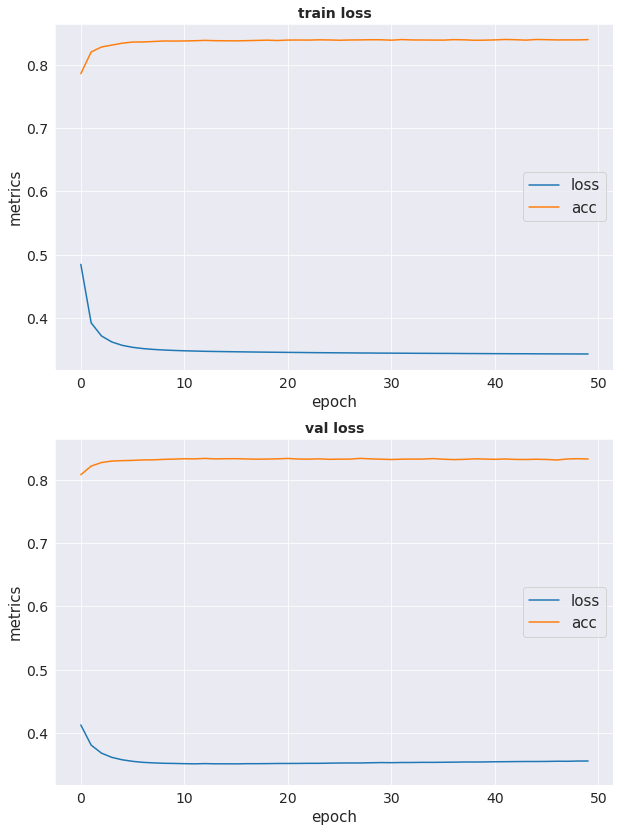

In [12]:
f = print_run(train_loss, test_loss)

---
### 2-2) Deep part
---

#### the Deep part : 
 - build the Wide part for generalizatoin
 - this part would be simple regression as same as the Wide part. But the differences are
 - concatenate of embedding layers for categorical and numerical features and Linear Layer
   - Input dimension : the sum of the number of output dimension of each embedding layers and the input number of Linear layer
   - Output dimension : one for regression output (activated with sigmoid function)

In [13]:
print(out_dataset['embeddings_input']) # column name / # of categorical vals / # embedding dims
print(out_dataset['deep_column_idx'])

[['education', 16, 10], ['relationship', 6, 8], ['workclass', 9, 10], ['native_country', 42, 12], ['occupation', 15, 10]]
{'education': 0, 'relationship': 1, 'workclass': 2, 'occupation': 3, 'native_country': 4, 'age': 5, 'hours_per_week': 6}


In [14]:
## sample embedding layer
sample_emb_info = out_dataset['embeddings_input'][0]
sample_emb_ly = nn.Embedding(sample_emb_info[1], sample_emb_info[2])
print(sample_emb_ly)

Embedding(16, 10)


In [15]:
d_train_x = torch.tensor(out_dataset['train_set'].deep, dtype=torch.float)
d_train_y = torch.tensor(out_dataset['train_set'].labels.reshape(-1,1), dtype=torch.float)
print(d_train_x.size(), d_train_y.size())

d_test_x = torch.tensor(out_dataset['test_set'].deep, dtype=torch.float)
d_test_y = torch.tensor(out_dataset['test_set'].labels.reshape(-1,1), dtype=torch.float)
print(d_test_x.size(), d_test_y.size())

batch_size = 64

d_train_set = TensorDataset(d_train_x, d_train_y)
d_train_loader = DataLoader(d_train_set, batch_size, shuffle = True, num_workers=1)

d_test_set = TensorDataset(d_test_x, d_test_y)
d_test_loader = DataLoader(d_test_set, batch_size, shuffle = True, num_workers=1)

torch.Size([34189, 7]) torch.Size([34189, 1])
torch.Size([14653, 7]) torch.Size([14653, 1])


In [16]:
### deep part network
class deepNet(nn.Module):
    
    def __init__(self, embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class):
        super(deepNet, self).__init__()
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.deep_column_idx = deep_column_idx
        self.n_hiddens = n_hiddens
        self.n_class = n_class
        
        
        # make embedding layers for categorical variables
        ## embedding : # of cols x # of embedding dims.
        for col, n_col, n_dim in self.embeddings_input:
            setattr(self, 'emb_ly_'+str(col), nn.Embedding(n_col, n_dim)) # (class, inst name, value)
            
        # add linear layer after concatenating of embedding layers and linear of continuous layer
        input_emb_dim = np.sum(emb[2] for emb in self.embeddings_input)
        self.ly1 = nn.Linear(input_emb_dim + len(continuous_cols), self.n_hiddens[0])
        # after concat hidden layers
        for i, hidden in enumerate(self.n_hiddens[1:],1):
            setattr(self, 'lin_ly_'+str(i+1), nn.Linear(self.n_hiddens[i-1], self.n_hiddens[i]))
            
        self.out_ly = nn.Linear(self.n_hiddens[-1], n_class)
            
    def forward(self, x):
        # make each output embedding layer's and return to type list 
        emb = [getattr(self, 'emb_ly_' +str(col))(x[:, self.deep_column_idx[col]].long()) for col, _, _ in self.embeddings_input]
        
        # for continuous values
        cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
        ## just slicing of continuous values
        cont = [x[:, cont_idx].float()]
        
        ## concatenating of embedding layer's outpus and linear inputs
        #### concat input of list to one array
        deep_input = torch.cat(emb+cont, 1)
        x_deep = F.relu(self.ly1(deep_input))
        
        for i in range(1, len(n_hiddens)): # first hidden value is already used in 'ly1' layer -> start from 1
            x_deep = F.relu( getattr(self, 'lin_ly_'+str(i+1))(x_deep))
        
        # final classifier layer
        out = F.sigmoid(self.out_ly(x_deep))
        
        return out

In [17]:
deep_column_idx = out_dataset['deep_column_idx']
embeddings_input= out_dataset['embeddings_input']
n_hiddens = [100,50]

d_net = deepNet(embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class)
print(d_net)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
d_net = d_net.to(device)

deepNet(
  (emb_ly_education): Embedding(16, 10)
  (emb_ly_relationship): Embedding(6, 8)
  (emb_ly_workclass): Embedding(9, 10)
  (emb_ly_native_country): Embedding(42, 12)
  (emb_ly_occupation): Embedding(15, 10)
  (ly1): Linear(in_features=52, out_features=100, bias=True)
  (lin_ly_2): Linear(in_features=100, out_features=50, bias=True)
  (out_ly): Linear(in_features=50, out_features=1, bias=True)
)


In [18]:
## Set the parameters and train/test the Wide part model
opt_fn = optim.Adam(d_net.parameters())
loss_fn = nn.BCELoss()

n_epochs = 50

d_net, train_loss, test_loss, best_val_acc, best_epoch_num = \
    train_model(d_net, device, d_train_loader, d_test_loader, opt_fn, loss_fn, n_epochs, log_num = 5)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Train] Epoch 1 / 50, Loss: 0.38, accuracy: 0.8251
[Test] Epoch 1 / 50, Loss: 0.349, accuracy: 0.8378

[Train] Epoch 6 / 50, Loss: 0.335, accuracy: 0.8452
[Test] Epoch 6 / 50, Loss: 0.342, accuracy: 0.8401

[Train] Epoch 11 / 50, Loss: 0.328, accuracy: 0.8478
[Test] Epoch 11 / 50, Loss: 0.343, accuracy: 0.8396

[Train] Epoch 16 / 50, Loss: 0.32, accuracy: 0.8507
[Test] Epoch 16 / 50, Loss: 0.349, accuracy: 0.8374

[Train] Epoch 21 / 50, Loss: 0.312, accuracy: 0.854
[Test] Epoch 21 / 50, Loss: 0.355, accuracy: 0.8366

[Train] Epoch 26 / 50, Loss: 0.305, accuracy: 0.8577
[Test] Epoch 26 / 50, Loss: 0.363, accuracy: 0.8342

[Train] Epoch 31 / 50, Loss: 0.297, accuracy: 0.8611
[Test] Epoch 31 / 50, Loss: 0.374, accuracy: 0.8336

[Train] Epoch 36 / 50, Loss: 0.291, accuracy: 0.8632
[Test] Epoch 36 / 50, Loss: 0.383, accuracy: 0.8326

[Train] Epoch 41 / 50, Loss: 0.285, accuracy: 0.8676
[Test] Epoch 41 / 50, Loss: 0.393, accuracy: 0.8283

[Train] Epoch 46 / 50, Loss: 0.28, accuracy: 0.8693
[

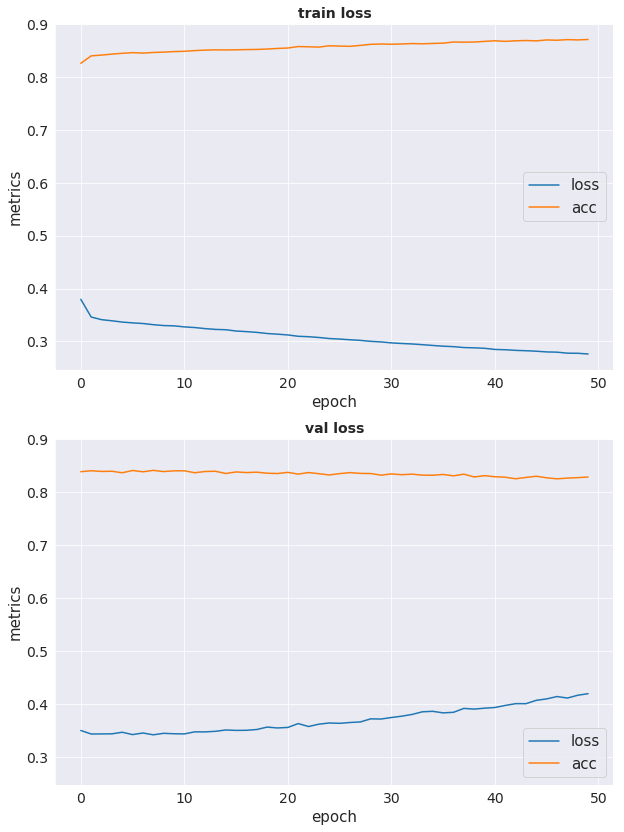

In [19]:
f = print_run(train_loss, test_loss)

---
#### 2-3) Wide and Deep Learning
---

#### the wide and deep learning model : 
 - combine the Wide part and the Deep part

#### 1st way : concat two models in a one model

In [20]:
w_train_x = torch.tensor(out_dataset['train_set'].wide, dtype=torch.float)
d_train_x = torch.tensor(out_dataset['train_set'].deep, dtype=torch.float)
train_y = torch.tensor(out_dataset['train_set'].labels.reshape(-1,1), dtype=torch.float)
print(w_train_x.size(), d_train_x.size(), train_y.size())

w_test_x = torch.tensor(out_dataset['test_set'].wide, dtype=torch.float)
d_test_x = torch.tensor(out_dataset['test_set'].deep, dtype=torch.float)
test_y = torch.tensor(out_dataset['test_set'].labels.reshape(-1,1), dtype=torch.float)
print(w_test_x.size(), d_test_x.size(), test_y.size())

batch_size = 64

t_train_set = TensorDataset(w_train_x, d_train_x, d_train_y)
t_train_loader = DataLoader(t_train_set, batch_size, shuffle = True, num_workers=1)

t_test_set = TensorDataset(w_test_x, d_test_x, d_test_y)
t_test_loader = DataLoader(t_test_set, batch_size, shuffle = True, num_workers=1)

torch.Size([34189, 798]) torch.Size([34189, 7]) torch.Size([34189, 1])
torch.Size([14653, 798]) torch.Size([14653, 7]) torch.Size([14653, 1])


In [21]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class Last_net(nn.Module):
    def __init__(self, input_dim, n_class):
        super(Last_net, self).__init__()
        self.input_dim = input_dim
        self.n_class = n_class
        
        self.out_ly = nn.Linear(self.input_dim, self.n_class)
        
        
    def forward(self, x):
        x = F.sigmoid(self.out_ly(x))
        
        return x

In [22]:
t_w_net = wideNet(wide_dim, n_class)
t_d_net = deepNet(embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class)

In [23]:
# t_w_net.ly1.out_features = 10 # [!!!!!!] this does not change the number of output dimensions
t_w_net.ly1 = nn.Linear(798,10)
print(t_w_net) # out dim = 10

t_d_net.out_ly = Identity() # change the last layer(classifier) as identity function
print(t_d_net) # out dim = 50

concat_dim = int(t_w_net.ly1.out_features) + int(t_d_net.lin_ly_2.out_features)
print('concat dim is {}'.format(concat_dim))

last_net = Last_net(concat_dim, n_class)
print(last_net)

wideNet(
  (ly1): Linear(in_features=798, out_features=10, bias=True)
)
deepNet(
  (emb_ly_education): Embedding(16, 10)
  (emb_ly_relationship): Embedding(6, 8)
  (emb_ly_workclass): Embedding(9, 10)
  (emb_ly_native_country): Embedding(42, 12)
  (emb_ly_occupation): Embedding(15, 10)
  (ly1): Linear(in_features=52, out_features=100, bias=True)
  (lin_ly_2): Linear(in_features=100, out_features=50, bias=True)
  (out_ly): Identity()
)
concat dim is 60
Last_net(
  (out_ly): Linear(in_features=60, out_features=1, bias=True)
)


In [24]:
class wide_and_deep_1(nn.Module):
    def __init__(self, wide_dim, embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class):
        super(wide_and_deep_1, self).__init__()

        self.wide_m = wideNet(wide_dim, n_class)
        self.wide_m.ly1 = nn.Linear(wide_dim, 10)
        
        self.deep_m = deepNet(embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class)
        self.deep_m.out_ly = Identity()
        
        self.concat_dim = int(self.wide_m.ly1.out_features) + int(self.deep_m.lin_ly_2.out_features)
        self.last_net = Last_net(self.concat_dim, n_class)
    
    def forward(self, x_w, x_d):
        o_w = self.wide_m(x_w)
        o_d = self.deep_m(x_d)
        input_last = torch.cat((o_w, o_d), 1)
        
        o_last = self.last_net(input_last)
        return o_last        

In [25]:
wide_and_deep_m = wide_and_deep_1(wide_dim, embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class)
print(wide_and_deep_m)

wide_and_deep_1(
  (wide_m): wideNet(
    (ly1): Linear(in_features=798, out_features=10, bias=True)
  )
  (deep_m): deepNet(
    (emb_ly_education): Embedding(16, 10)
    (emb_ly_relationship): Embedding(6, 8)
    (emb_ly_workclass): Embedding(9, 10)
    (emb_ly_native_country): Embedding(42, 12)
    (emb_ly_occupation): Embedding(15, 10)
    (ly1): Linear(in_features=52, out_features=100, bias=True)
    (lin_ly_2): Linear(in_features=100, out_features=50, bias=True)
    (out_ly): Identity()
  )
  (last_net): Last_net(
    (out_ly): Linear(in_features=60, out_features=1, bias=True)
  )
)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


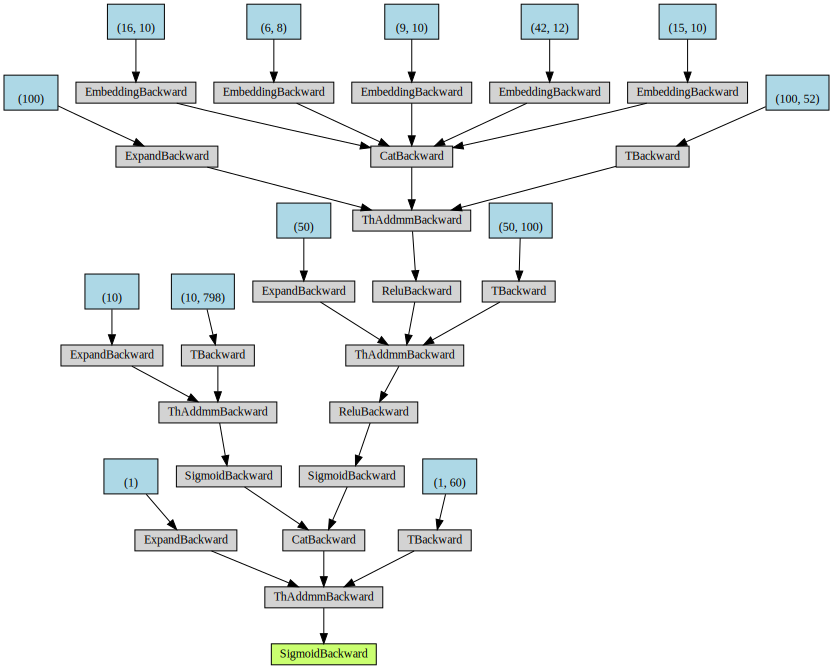

In [26]:
## Model visualization
%matplotlib inline
from dot import make_dot, parse

inputs = iter(t_train_loader).next()
y = wide_and_deep_m(inputs[0], inputs[1])
# print(y)
g = make_dot(y)
g

In [27]:
loss_fn = nn.BCELoss()

# w_net / d_net
wide_and_deep_m = wide_and_deep_m.to(device)
opt_fn = optim.Adam(wide_and_deep_m.parameters())

n_epochs = 50
log_num = 10

In [28]:
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    #################################################
    ## Training Part
    #################################################
    running_total =0.0
    running_correct =0.0
    running_loss = 0.0

    for i, data in enumerate(t_train_loader):
        inputs_w, inputs_d, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # zerograd
        opt_fn.zero_grad()

        # forward
        y_pred = wide_and_deep_m(inputs_w, inputs_d)        
        loss = loss_fn(y_pred, labels)

        # backward
        loss.backward()
        opt_fn.step()


        ############
        # 1) loss
        running_loss += loss.item()*inputs_w.size(0)

        ############
        # 2) metric
        y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
        running_correct+= float((y_pred_cnvt == labels.squeeze(1)).sum().item())

        running_total += y_pred.size(0) # total number of samples (accumulated)

    #################################################
    ## train epoch loss
    epoch_loss = running_loss / int(running_total)
    epoch_acc = running_correct / int(running_total)

    train_loss.append((epoch, epoch_loss, 'loss'))
    train_loss.append((epoch, epoch_acc, 'acc'))

    if (epoch+1)%log_num == 1:
        print ('[Train] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
            n_epochs, round(epoch_loss,3), round(epoch_acc,4)))

    #################################################
    ## Test Part
    #################################################
    running_total = 0.0
    running_correct = 0.0
    running_loss = 0.0

    for i, data in enumerate(t_test_loader):
        inputs_w, inputs_d, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # forward
        y_pred = wide_and_deep_m(inputs_w, inputs_d)        
        loss = loss_fn(y_pred, labels)

        ############
        # 1) loss
        running_loss += loss.item()*inputs_w.size(0)

        ############
        # 2) metric
        y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
        running_correct += float((y_pred_cnvt == labels.squeeze(1)).sum().item())

        running_total += y_pred.size(0) # total number of samples (accumulated)

    #################################################
    ## test epoch loss
    epoch_loss = running_loss / int(running_total)
    epoch_acc = running_correct / int(running_total)

    test_loss.append((epoch, epoch_loss, 'loss'))
    test_loss.append((epoch, epoch_acc, 'acc'))

    if (epoch+1)%log_num == 1:
        print ('[Test] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
            n_epochs, round(epoch_loss,3), round(epoch_acc,4)))
        print()

    if best_val_acc < epoch_acc:
        best_val_acc = epoch_acc
        best_epoch_num = epoch + 1

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Train] Epoch 1 / 50, Loss: 0.411, accuracy: 0.8057
[Test] Epoch 1 / 50, Loss: 0.365, accuracy: 0.8281

[Train] Epoch 11 / 50, Loss: 0.33, accuracy: 0.8478
[Test] Epoch 11 / 50, Loss: 0.343, accuracy: 0.8375

[Train] Epoch 21 / 50, Loss: 0.322, accuracy: 0.8504
[Test] Epoch 21 / 50, Loss: 0.345, accuracy: 0.8366

[Train] Epoch 31 / 50, Loss: 0.313, accuracy: 0.8545
[Test] Epoch 31 / 50, Loss: 0.349, accuracy: 0.8408

[Train] Epoch 41 / 50, Loss: 0.306, accuracy: 0.8569
[Test] Epoch 41 / 50, Loss: 0.358, accuracy: 0.836



#### 2nd way : concat two models in training steps

In [29]:
t_w_net = t_w_net.to(device)
t_d_net = t_d_net.to(device)
last_net = last_net.to(device)

In [30]:
loss_fn = nn.BCELoss()

# w_net / d_net
opt_fn = optim.Adam(list(t_w_net.parameters()) + list(t_d_net.parameters()) + list(last_net.parameters()))

n_epochs = 50
log_num = 10

In [31]:
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    #################################################
    ## Training Part
    #################################################
    running_total =0.0
    running_correct =0.0
    running_loss = 0.0

    for i, data in enumerate(t_train_loader):
        inputs_w, inputs_d, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # zerograd
        opt_fn.zero_grad()

        # forward
        y_pred_w = t_w_net(inputs_w)
        y_pred_d = t_d_net(inputs_d)
        y_pred_tot = torch.cat((y_pred_w, y_pred_d), 1)
        
        y_pred = last_net(y_pred_tot)
        
        loss = loss_fn(y_pred, labels)

        # backward
        loss.backward()
        opt_fn.step()


        ############
        # 1) loss
        running_loss += loss.item()*inputs_w.size(0)

        ############
        # 2) metric
        y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
        running_correct+= float((y_pred_cnvt == labels.squeeze(1)).sum().item())

        running_total += y_pred.size(0) # total number of samples (accumulated)

    #################################################
    ## train epoch loss
    epoch_loss = running_loss / int(running_total)
    epoch_acc = running_correct / int(running_total)

    train_loss.append((epoch, epoch_loss, 'loss'))
    train_loss.append((epoch, epoch_acc, 'acc'))

    if (epoch+1)%log_num == 1:
        print ('[Train] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
            n_epochs, round(epoch_loss,3), round(epoch_acc,4)))

    #################################################
    ## Test Part
    #################################################
    running_total = 0.0
    running_correct = 0.0
    running_loss = 0.0

    for i, data in enumerate(t_test_loader):
        inputs_w, inputs_d, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # forward
        y_pred_w = t_w_net(inputs_w)
        y_pred_d = t_d_net(inputs_d)
        y_pred_tot = torch.cat((y_pred_w, y_pred_d), 1)
        
        y_pred = last_net(y_pred_tot)
        
        loss = loss_fn(y_pred, labels)

        ############
        # 1) loss
        running_loss += loss.item()*inputs_w.size(0)

        ############
        # 2) metric
        y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
        running_correct += float((y_pred_cnvt == labels.squeeze(1)).sum().item())

        running_total += y_pred.size(0) # total number of samples (accumulated)

    #################################################
    ## test epoch loss
    epoch_loss = running_loss / int(running_total)
    epoch_acc = running_correct / int(running_total)

    test_loss.append((epoch, epoch_loss, 'loss'))
    test_loss.append((epoch, epoch_acc, 'acc'))

    if (epoch+1)%log_num == 1:
        print ('[Test] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
            n_epochs, round(epoch_loss,3), round(epoch_acc,4)))
        print()

    if best_val_acc < epoch_acc:
        best_val_acc = epoch_acc
        best_epoch_num = epoch + 1

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Train] Epoch 1 / 50, Loss: 0.409, accuracy: 0.8085
[Test] Epoch 1 / 50, Loss: 0.365, accuracy: 0.8291

[Train] Epoch 11 / 50, Loss: 0.33, accuracy: 0.8464
[Test] Epoch 11 / 50, Loss: 0.342, accuracy: 0.8394

[Train] Epoch 21 / 50, Loss: 0.321, accuracy: 0.8506
[Test] Epoch 21 / 50, Loss: 0.346, accuracy: 0.8381

[Train] Epoch 31 / 50, Loss: 0.313, accuracy: 0.8534
[Test] Epoch 31 / 50, Loss: 0.35, accuracy: 0.8355

[Train] Epoch 41 / 50, Loss: 0.307, accuracy: 0.8563
[Test] Epoch 41 / 50, Loss: 0.355, accuracy: 0.8356



#### thrid way : start from one combined model

In [32]:
### deep part network (completely build for one model)
class widedeepNet(nn.Module):
    
    def __init__(self, wide_dim, embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class):
        super(widedeepNet, self).__init__()
        self.wide_dim = wide_dim
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.deep_column_idx = deep_column_idx
        self.n_hiddens = n_hiddens
        self.n_class = n_class
        
        print(self.deep_column_idx)
        
        # make embedding layers for categorical variables
        ## embedding : # of cols x # of embedding dims.
        for col, n_col, n_dim in self.embeddings_input:
            setattr(self, 'emb_ly_'+str(col), nn.Embedding(n_col, n_dim)) # (class, inst name, value)
            
        # add linear layer after concatenating of embedding layers and linear of continuous layer
        input_emb_dim = np.sum(emb[2] for emb in self.embeddings_input)
        print(input_emb_dim)
        self.ly1 = nn.Linear(input_emb_dim + len(continuous_cols), self.n_hiddens[0])
        # after concat hidden layers
        for i, hidden in enumerate(self.n_hiddens[1:],1):
            setattr(self, 'lin_ly_'+str(i+1), nn.Linear(self.n_hiddens[i-1], self.n_hiddens[i]))
            
        self.out_ly = nn.Linear(self.n_hiddens[-1] + self.wide_dim, n_class)
            
    def forward(self, x_w, x_d):
        # make each output embedding layer's and return to type list 
        emb = [getattr(self, 'emb_ly_' +str(col))(x_d[:, self.deep_column_idx[col]].long()) for col, _, _ in self.embeddings_input]
        
        # for continuous values
        cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
        ## just slicing of continuous values
        cont = [x_d[:, cont_idx].float()]
        
        ## concatenating of embedding layer's outpus and linear inputs
        #### concat input of list to one array
        deep_input = torch.cat(emb+cont, 1)
        x_deep = F.relu(self.ly1(deep_input))
        
        for i in range(1, len(n_hiddens)): # first hidden value is already used in 'ly1' layer -> start from 1
            x_deep = F.relu( getattr(self, 'lin_ly_'+str(i+1))(x_deep))
        
        
        ## concat of wide and deep
        x_wide = x_w.float()
        
        x_wide_deep = torch.cat((x_wide, x_deep), 1)        
        
        # final classifier layer
        out = F.sigmoid(self.out_ly(x_wide_deep))
        
        return out

{'education': 0, 'relationship': 1, 'workclass': 2, 'occupation': 3, 'native_country': 4, 'age': 5, 'hours_per_week': 6}
50
widedeepNet(
  (emb_ly_education): Embedding(16, 10)
  (emb_ly_relationship): Embedding(6, 8)
  (emb_ly_workclass): Embedding(9, 10)
  (emb_ly_native_country): Embedding(42, 12)
  (emb_ly_occupation): Embedding(15, 10)
  (ly1): Linear(in_features=52, out_features=100, bias=True)
  (lin_ly_2): Linear(in_features=100, out_features=50, bias=True)
  (out_ly): Linear(in_features=848, out_features=1, bias=True)
)


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fb9a228bb38>>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File

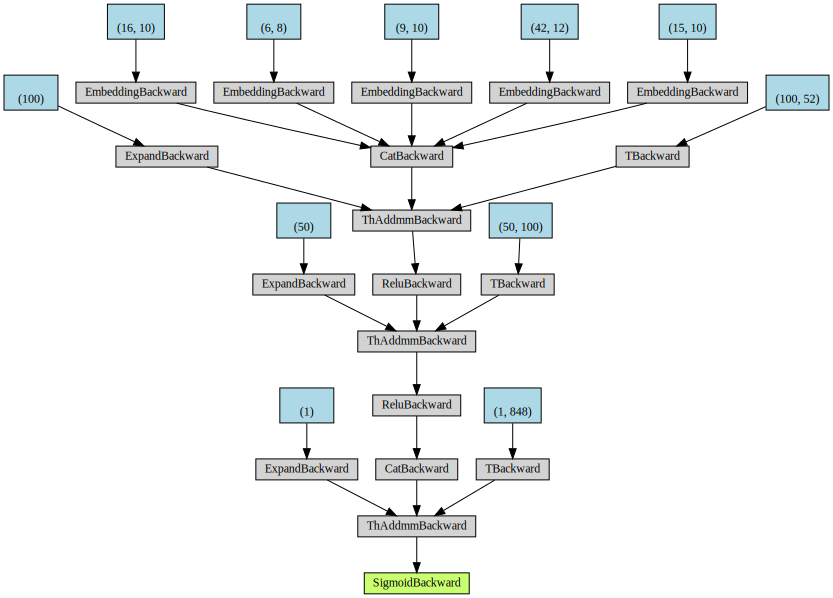

In [37]:
wide_dim = out_dataset['train_set'].wide.shape[1]
deep_column_idx = out_dataset['deep_column_idx']
embeddings_input= out_dataset['embeddings_input']
n_hiddens = [100,50]

wd_net = widedeepNet(wide_dim, embeddings_input, continuous_cols, deep_column_idx, n_hiddens, n_class)
print(wd_net)

## Model visualization
%matplotlib inline
from dot import make_dot, parse

inputs = iter(t_train_loader).next()
y = wd_net(inputs[0], inputs[1])
# print(y)
g = make_dot(y)
g

In [38]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
wd_net = wd_net.to(device)

In [39]:
loss_fn = nn.BCELoss()

# w_net / d_net
opt_fn = optim.Adam(wd_net.parameters())

n_epochs = 50
log_num = 10

In [40]:
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    #################################################
    ## Training Part
    #################################################
    running_total =0.0
    running_correct =0.0
    running_loss = 0.0

    for i, data in enumerate(t_train_loader):
        inputs_w, inputs_d, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # zerograd
        opt_fn.zero_grad()

        # forward
        y_pred = wd_net(inputs_w, inputs_d)
        loss = loss_fn(y_pred, labels)

        # backward
        loss.backward()
        opt_fn.step()


        ############
        # 1) loss
        running_loss += loss.item()*inputs_w.size(0)

        ############
        # 2) metric
        y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
        running_correct+= float((y_pred_cnvt == labels.squeeze(1)).sum().item())

        running_total += y_pred.size(0) # total number of samples (accumulated)

    #################################################
    ## train epoch loss
    epoch_loss = running_loss / int(running_total)
    epoch_acc = running_correct / int(running_total)

    train_loss.append((epoch, epoch_loss, 'loss'))
    train_loss.append((epoch, epoch_acc, 'acc'))

    if (epoch+1)%log_num == 1:
        print ('[Train] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
            n_epochs, round(epoch_loss,3), round(epoch_acc,4)))

    #################################################
    ## Test Part
    #################################################
    running_total = 0.0
    running_correct = 0.0
    running_loss = 0.0

    for i, data in enumerate(t_test_loader):
        inputs_w, inputs_d, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        # forward
        y_pred = wd_net(inputs_w, inputs_d)        
        loss = loss_fn(y_pred, labels)

        ############
        # 1) loss
        running_loss += loss.item()*inputs_w.size(0)

        ############
        # 2) metric
        y_pred_cnvt = (y_pred > 0.5).squeeze(1).float() # (= (y_pred > 0.5).view(-1))
        running_correct += float((y_pred_cnvt == labels.squeeze(1)).sum().item())

        running_total += y_pred.size(0) # total number of samples (accumulated)

    #################################################
    ## test epoch loss
    epoch_loss = running_loss / int(running_total)
    epoch_acc = running_correct / int(running_total)

    test_loss.append((epoch, epoch_loss, 'loss'))
    test_loss.append((epoch, epoch_acc, 'acc'))

    if (epoch+1)%log_num == 1:
        print ('[Test] Epoch {} / {}, Loss: {}, accuracy: {}'.format(epoch+1,
            n_epochs, round(epoch_loss,3), round(epoch_acc,4)))
        print()

    if best_val_acc < epoch_acc:
        best_val_acc = epoch_acc
        best_epoch_num = epoch + 1

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Train] Epoch 1 / 50, Loss: 0.383, accuracy: 0.8212
[Test] Epoch 1 / 50, Loss: 0.348, accuracy: 0.8359

[Train] Epoch 11 / 50, Loss: 0.327, accuracy: 0.8479
[Test] Epoch 11 / 50, Loss: 0.34, accuracy: 0.8395

[Train] Epoch 21 / 50, Loss: 0.312, accuracy: 0.8551
[Test] Epoch 21 / 50, Loss: 0.353, accuracy: 0.8363

[Train] Epoch 31 / 50, Loss: 0.297, accuracy: 0.8602
[Test] Epoch 31 / 50, Loss: 0.368, accuracy: 0.8342

[Train] Epoch 41 / 50, Loss: 0.283, accuracy: 0.8681
[Test] Epoch 41 / 50, Loss: 0.393, accuracy: 0.8327



In [41]:
n1 = list(w_net.children())
n2 = list(d_net.children())

n = n1 + n2
print(n)

w_d_net = nn.Sequential(*n)
print(w_d_net)

[Linear(in_features=798, out_features=1, bias=True), Embedding(16, 10), Embedding(6, 8), Embedding(9, 10), Embedding(42, 12), Embedding(15, 10), Linear(in_features=52, out_features=100, bias=True), Linear(in_features=100, out_features=50, bias=True), Linear(in_features=50, out_features=1, bias=True)]
Sequential(
  (0): Linear(in_features=798, out_features=1, bias=True)
  (1): Embedding(16, 10)
  (2): Embedding(6, 8)
  (3): Embedding(9, 10)
  (4): Embedding(42, 12)
  (5): Embedding(15, 10)
  (6): Linear(in_features=52, out_features=100, bias=True)
  (7): Linear(in_features=100, out_features=50, bias=True)
  (8): Linear(in_features=50, out_features=1, bias=True)
)
